In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import seaborn as sns
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers

In [2]:
# !unzip data.zip

In [3]:
x, y = [],[]
n = 2920
for k in tqdm(range(1,8)):
    a = 0
    if(k == 1 or k == 2):
        a = 1
    for i in range(a,n+1,2):
        try:
            img = cv2.imread(f'./data/{k}/{i}.jpg', 0)
            x.append(img/255)
            y.append(k)
        except:
            print('error at k, i = ', (k,i))

In [4]:
X = np.array(x)
X /= X.max()
y = np.array(y).reshape(-1,1)

In [6]:
# Metrics for checking the model performance while training
import tensorflow as tf
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [7]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.999):
      self.model.stop_training = True

In [8]:
K.clear_session()
model=Sequential()
model.add(Conv2D(filters = 32, kernel_size = (64,64), padding='same', input_shape = (150,150,1), activation='relu'))
model.add(Conv2D(filters = 64, kernel_size = (16,16), padding='same', input_shape = (150,150,1), activation='relu'))
model.add(Conv2D(filters = 128, kernel_size = (4,4), padding='same', input_shape = (150,150,1), activation='relu'))
model.add(MaxPool2D(pool_size = (4,4)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=[custom_f1score])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      131104    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      524352    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 128)     131200    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                5607456   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2

In [ ]:
# callbacks = [stop_training_callback()]
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i+13)
    X_train = X_train.reshape(-1,150,150,1)
    X_test = X_test.reshape(-1,150,150,1)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, verbose=1)

Train on 8180 samples, validate on 2045 samples
  32/8180 [..............................] - ETA: 8:08:24 - loss: 2.0765 - custom_f1score: 0.1250

In [19]:
y_test_pred = model.predict_classes(X_test)

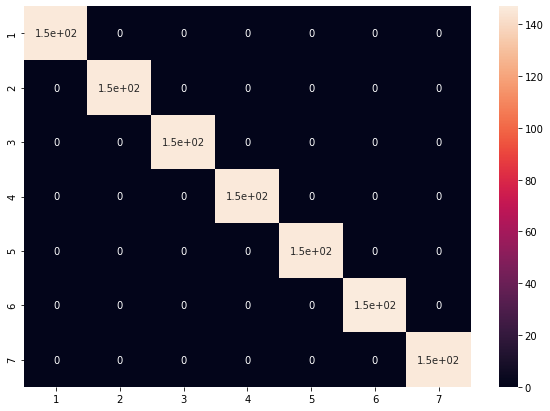

In [20]:
cm = confusion_matrix(y_test, y_test_pred)
df_cm = pd.DataFrame(cm, index=np.arange(1,8), columns=np.arange(1,8))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

prediction ----->  1
prediction ----->  2
prediction ----->  3
prediction ----->  4
prediction ----->  5
prediction ----->  6
prediction ----->  7


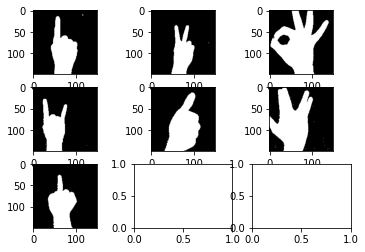

In [21]:
zz = [1450*i if(e>1) else 1450*i-1 for e,i in enumerate(range(1,8))]
fig, ax = plt.subplots(3, 3)
for i,z in enumerate(zz):
    t = x[z]
    im = np.array([t])
    im = im.reshape(-1,150,150,1)
    w, v = i//3, i%3
    ax[w, v].imshow(t, cmap='gray')
    res = model.predict(im)
#     res= np.array([1,2,3])
    print('prediction -----> ', res.argmax())
plt.show()

In [22]:
model.save('cnn_model_emoji_single_hand.h5')